In [1]:
import poppy
import copy
import pickle
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.transform import resize

%matplotlib inline

In [2]:
## BEGIN USER-DEFINED QUANTITIES

# initial focal length of lens (um) in the substrate
f_lens_substr = 284.664*u.micron
f_lens = f_lens_substr

# pixel scale of 'detector' (plane of waveguide entrance)
scale_wg = 0.2161*u.micron/u.pix

# lenslet diameter
diam_lenslet = 66.*u.micron

# index of refraction of substrate
n_glass = 1.5255

## LOOP THIS
# wavelength in air (n = 1)
wavel_air = 1.55*u.micron

## END USER-DEFINED QUANTITIES

In [3]:
# derived quantities

# wavelength in substrate
wavel_substr = (wavel_air/n_glass)
wavel = wavel_substr

# radius of first dark ring in um
circ_r_um = 1.22 * wavel_substr * f_lens_substr/diam_lenslet

print('radius of first dark Airy ring (um):',circ_r_um)

radius of first dark Airy ring (um): 5.346479783081552 micron


In [4]:
# read in waveguide mode

'''
S. Gross:

The waveguide modes have a 4sigma diameter of 8.3x7.6um. 
A simple Gaussian fit gives a 1/e2 diameter of 5.8x5.4um. 
Both at a wavelength of 1550nm.

The attached CSV file contains the corresponding intensity profile. 
The scale is 0.2161um per pixel.
'''

# retrieve waveguide intensity and make cutout
stem = '/Users/bandari/Documents/git.repos/glint_misc/notebooks/data/'
open_file = open(stem + 'waveguide_intensity.pkl', "rb")
df_intensity, xycen = pickle.load(open_file)
open_file.close()
# cutouts
buffer = 100 # pix
waveguide_cutout = df_intensity[int(xycen[1]-buffer):int(xycen[1]+buffer),int(xycen[0]-buffer):int(xycen[0]+buffer)]

In [5]:
# physical dims of waveguide pattern

x_dim_waveguide, y_dim_waveguide = np.multiply(np.shape(waveguide_cutout),scale_wg*u.pixel)

In [10]:
print('Waveguide mode spatial shape:',(x_dim_waveguide,y_dim_waveguide))
print('Waveguide mode pixel shape:',np.shape(waveguide_cutout))

Waveguide mode spatial shape: (<Quantity 43.22 micron>, <Quantity 43.22 micron>)
Waveguide mode pixel shape: (200, 200)


(<Axes: title={'center': 'Wavefront amplitude'}, xlabel='m', ylabel='m'>,
 <Axes: title={'center': 'Wavefront phase'}, xlabel='m'>)

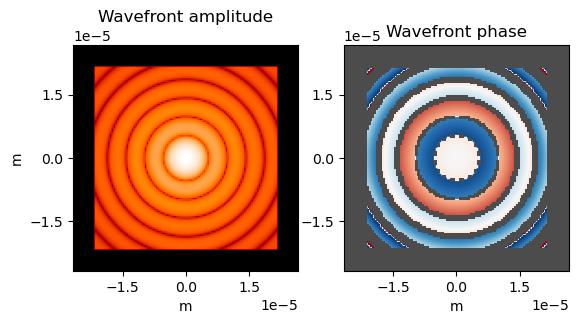

In [11]:
# construct Fresnel system with lens of focal length f um and project image

npix = 512 # ~512 is minimum to accurately recover the central diffraction spike

## LOOP THIS
z = f_lens # propagation distance

wf = poppy.FresnelWavefront(beam_radius=0.5*diam_lenslet, wavelength=wavel, npix=npix, oversample=10)
wf *= poppy.CircularAperture(radius=0.5*diam_lenslet) 

conv_lens = poppy.QuadraticLens(f_lens=f_lens)
wf *= conv_lens

# propagate over distance z
wf.propagate_fresnel(z)

# wavefront on MLA
#wf_1 = copy.deepcopy(wf)

#det = osys_circ.add_detector(pixelscale=pixelscale_ang, fov_pixels=100)

# crop to the physical size of the waveguide cutout by using rectangular aperture
wf *= poppy.RectangleAperture(width=x_dim_waveguide, height=y_dim_waveguide)
# remove residual zeros on edges
x, y = np.nonzero(wf.amplitude)
xl,xr = x.min(),x.max()
yl,yr = y.min(),y.max()
wf_amp_cropped = wf.amplitude[xl:xr+1, yl:yr+1]
wf_phase_cropped = wf.phase[xl:xr+1, yl:yr+1]

#wf_2 = copy.deepcopy(wf)

wf.display('both', scale='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5, 
           imagecrop=10.*circ_r_um)


In [15]:
# ratio of wf spatial scale to waveguide scale

scale_wf = wf.pixelscale.to(u.micron/u.pix)

scale_wf_2_wg = scale_wf/scale_wg

print('Raw spatial scale_wf:',scale_wf)
print('Raw spatial scale_wg:',scale_wg)

Raw spatial scale_wf: 0.4351260246441879 micron / pix
Raw spatial scale_wg: 0.2161 micron / pix


In [16]:
# rescale shape of waveguide mode array

In [18]:
# >1 means 'waveguide is this much finer than wavefront'
scale_wf_2_wg = scale_wf/scale_wg

In [23]:
new_shape_wavefront = np.array(np.shape(wf_amp_cropped)*scale_wf_2_wg).astype(int)

print('Shape of waveguide cutout:',np.shape(waveguide_cutout))
print('Calculate new shape of rescaled wavefront (should be almost identical to waveguide cutout):',new_shape_wavefront)

Shape of waveguide cutout: (200, 200)
Calculate new shape of rescaled wavefront (should be almost identical to waveguide cutout): [199 199]


In [62]:
# rescale wavefront to match waveguide

wf_amp_rescaled = resize(wf_amp_cropped,np.shape(waveguide_cutout))
wf_phase_rescaled = resize(wf_phase_cropped,np.shape(waveguide_cutout))

In [63]:
# define fields for overlap integral (should just be 200x200 arrays)
input_field = wf_amp_rescaled * np.exp(1j*wf_phase_rescaled)
mode_field = np.sqrt(waveguide_cutout) # sqrt because cutout is the intensity I, and we want E

# overlap integral
overlap_int_complex = np.sum(input_field*mode_field) / np.sqrt( np.sum(np.abs(mode_field)**2) * np.sum(np.abs(input_field)**2) )
overlap_int = np.abs(overlap_int_complex)**2

In [64]:
overlap_int

0.6228898413782504

In [39]:
# for secondary physical axes: 0.2161um per pixel.

def pix2um(x):
    return x*0.2161

def um2pix(x):
    return x/0.2161

circ_r_pix = um2pix(circ_r_um)/u.micron # divide out units

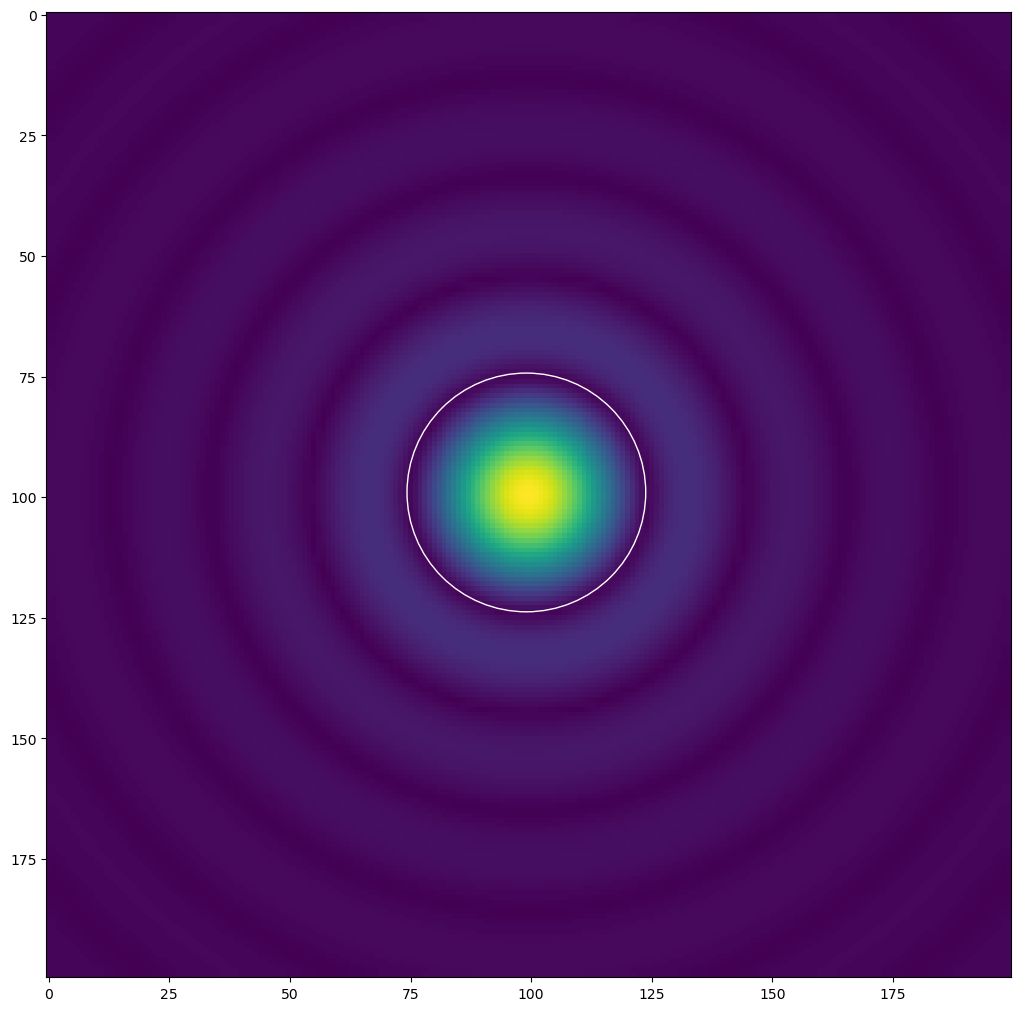

In [59]:
circ_cen_x = np.shape(wf_amp_cropped)[0]
circ_cen_y = np.shape(wf_amp_cropped)[1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), layout='constrained')
ax.imshow(wf_amp_rescaled,norm='linear')
ax.add_patch(Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False))
plt.show()

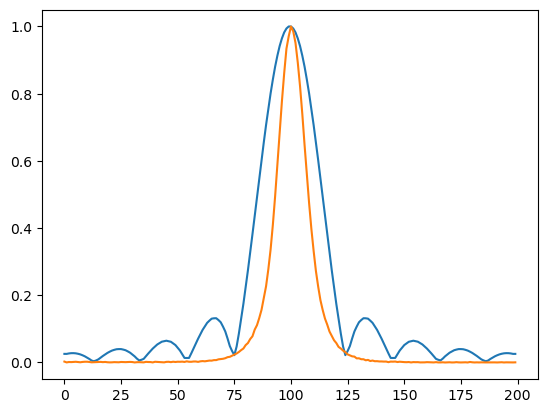

In [27]:
plt.plot(wf_amp_rescaled[100,:]/np.max(wf_amp_rescaled))
plt.plot(waveguide_cutout[100,:]/np.max(waveguide_cutout))
plt.show()

In [ ]:
# -----------------------------------------------------